# Tensorflow Model

In [3]:
from os import path
from random import sample, seed

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [4]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

BATCH_SIZE = 32
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 2000
EPOCHS = 10

seed(50)

### Load, split, and normalize the training data

In [5]:
def load_raw_evalmetrics_df():
    return pd.read_pickle(path.join('.', 'raw_evalmetrics_df.pkl'))

def prep_multivarate(df):
    """ Calculates density and removes unnecessary columns """
    new_df = df.copy()
    new_df['density'] = df.latestTotalPopulation / df.LND110210
    new_df = new_df.drop(columns=['latestTotalPopulation','fips','LND110210'])
    return new_df

def split_sample(df, percent_train=.80):
    county = set(df.county)
    train_county = sample(county, int(len(county) * percent_train))
    val_county = county - set(train_county)
    train_filter = [c in train_county for c in df.county]
    val_filter = [c in val_county for c in df.county]
    return df[train_filter].fillna(0), df[val_filter].fillna(0)

def normalize_df(train_df, val_df):
    new_train_df = train_df.copy()
    new_val_df = val_df.copy()
    cols = ['confirmed_cases','confirmed_recoveries','hospitalIcuBeds',
            'hospitalStaffedBeds','hospitalLicensedBeds', 'density']
    for col in cols:
        # calculate mean and std on training data only
        data = new_train_df[col].astype('float')
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
        new_train_df[col] = (data-data_mean)/data_std
        #apply to val data
        data = new_val_df[col].astype('float')
        new_val_df[col] = (data-data_mean)/data_std
    return new_train_df.fillna(0), new_val_df.fillna(0)

def get_data():
    evalmetric_df = load_raw_evalmetrics_df()
    prepped_df = prep_multivarate(evalmetric_df)
    train_df, val_df = split_sample(prepped_df)
    return normalize_df(train_df, val_df)



### Prep the data for RNN

In [6]:
# inspired by https://www.tensorflow.org/tutorials/structured_data/time_series


def multivariate_data(dataset, target_col, history_size=20, target_size=0):
    data = []
    labels = []
    
    counties = set(dataset.county)
    
    for j, county in enumerate(counties):
        if (j + 1) % 100 == 0:
            print('.', end='')
        sub_dataset = dataset[dataset.county == county]
        target = sub_dataset[target_col].values
        sub_dataset = sub_dataset.drop(columns=['county', 'date'])
        sub_dataset = sub_dataset.values
        start_index = history_size
        end_index = len(sub_dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            data.append(sub_dataset[indices])

            labels.append(target[i+target_size])

    print()
    return np.array(data), np.array(labels)



### Build the Tensorflow model

In [9]:
def slice_cache_for_tensorflow(x_train, y_train, x_val, y_val):
    x_train = np.asarray(x_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE, seed=50).batch(BATCH_SIZE).repeat()

    x_val = np.asarray(x_val).astype(np.float32)
    y_val = np.asarray(y_val).astype(np.float32)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.batch(BATCH_SIZE).repeat()
    
    return train_data, val_data

def build_and_compile_model(x_train):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:]))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
    return model

def build_and_compile_deep_model(x_train):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
    model.add(tf.keras.layers.LSTM(16, activation='relu'))
    model.add(tf.keras.layers.Dense(72))
    # model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mae')
    return model


def fit_model(model, train_data, val_data):
    history = model.fit(train_data, epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data,
                            validation_steps=50)
    return history
    
    

In [10]:
tf.random.set_seed(50)
train_df, val_df = get_data()
x_train, y_train = multivariate_data(train_df, 'confirmed_deaths')
x_val, y_val = multivariate_data(val_df, 'confirmed_deaths')

train_data, val_data = slice_cache_for_tensorflow(x_train, y_train, x_val, y_val)
shallow_model = build_and_compile_model(x_train)
deep_model = build_and_compile_deep_model(x_train)
shallow_history = fit_model(shallow_model, train_data, val_data)
deep_history = fit_model(deep_model, train_data, val_data)






...........
..
Epoch 1/10
2000/2000 [==============================] - 11s 6ms/step - loss: 8.3434 - val_loss: 2.1396
Epoch 2/10
2000/2000 [==============================] - 12s 6ms/step - loss: 5.4604 - val_loss: 2.1324
Epoch 3/10
2000/2000 [==============================] - 11s 6ms/step - loss: 7.3353 - val_loss: 2.1283
Epoch 4/10
2000/2000 [==============================] - 11s 6ms/step - loss: 7.6787 - val_loss: 2.1305
Epoch 5/10
2000/2000 [==============================] - 12s 6ms/step - loss: 7.0920 - val_loss: 2.1478
Epoch 6/10
2000/2000 [==============================] - 11s 6ms/step - loss: 8.2477 - val_loss: 2.1261
Epoch 7/10
2000/2000 [==============================] - 11s 6ms/step - loss: 6.3523 - val_loss: 2.1073
Epoch 8/10
2000/2000 [==============================] - 14s 7ms/step - loss: 7.7613 - val_loss: 2.0658
Epoch 9/10
2000/2000 [==============================] - 14s 7ms/step - loss: 6.4675 - val_loss: 2.0265
Epoch 10/10
2000/2000 [==============================] - 1

In [23]:
# train_df, val_df = get_data()
# x_train, y_train = multivariate_data(train_df, 'confirmed_deaths')
# x_val, y_val = multivariate_data(val_df, 'confirmed_deaths')

print(len(val_df))
print(len(x_val))
display(val_df[0:5])
x_val.shape

27392
23495


,county,date,confirmed_cases,confirmed_deaths,confirmed_recoveries,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,density
147,Accomack_Virginia_UnitedStates,2020-01-01,-0.041007,0.0,0.0,-0.353323,-0.394495,-0.404436,-0.322686
882,Adams_Mississippi_UnitedStates,2020-01-01,-0.041007,0.0,0.0,-0.322885,-0.322194,-0.337264,-0.327617
1186,Adams_Pennsylvania_UnitedStates,2020-01-01,-0.041007,0.0,0.0,-0.365498,-0.373020,-0.389370,-0.209436
1627,Alamance_NorthCarolina_UnitedStates,2020-01-01,-0.041007,0.0,0.0,-0.292447,-0.301434,-0.287671,-0.029571
1921,Albany_NewYork_UnitedStates,2020-01-01,-0.041007,0.0,0.0,0.291963,0.630606,0.524038,0.135352


(23495, 20, 7)

### Plots

In [12]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

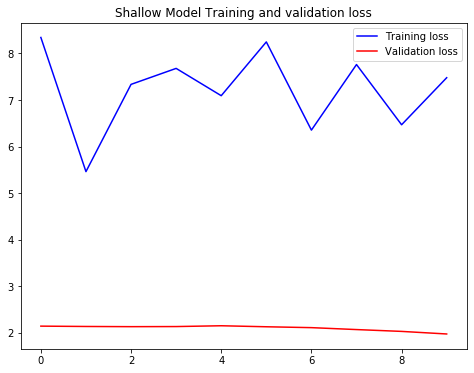

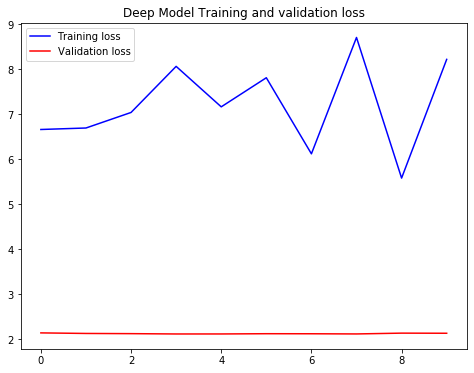

In [13]:
plot_train_history(shallow_history,
                   'Shallow Model Training and validation loss')

plot_train_history(deep_history,
                   'Deep Model Training and validation loss')

In [16]:
shallow_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [17]:
deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 32)            5120      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                1224      
Total params: 9,480
Trainable params: 9,480
Non-trainable params: 0
_________________________________________________________________


In [144]:
history

In [21]:
def create_time_steps(length):
    return list(range(-length, 0))


In [25]:
def show_plot(plot_data, delta, title):
    
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
#     plt.xlim([time_steps[0], (future+5)*2])
    plt.xlim([time_steps[0], 1])
    plt.xlabel('Time-Step')
    return plt

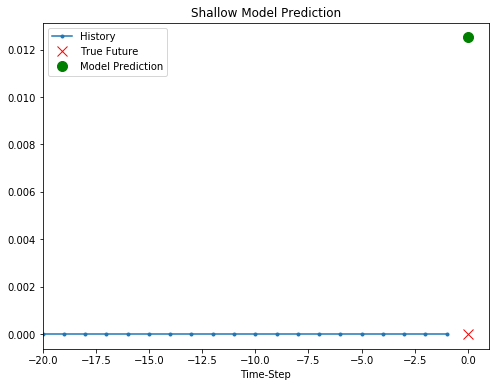

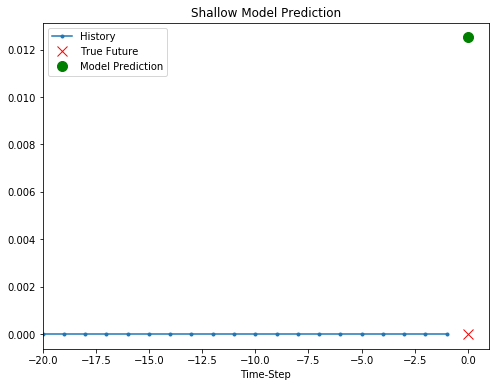

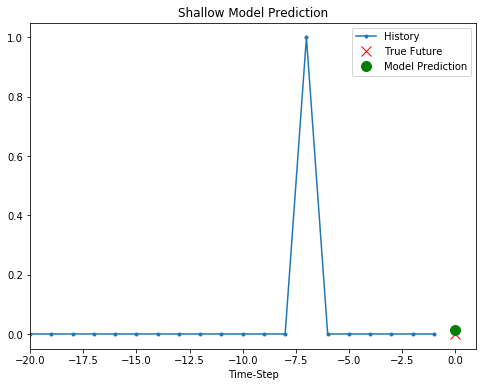

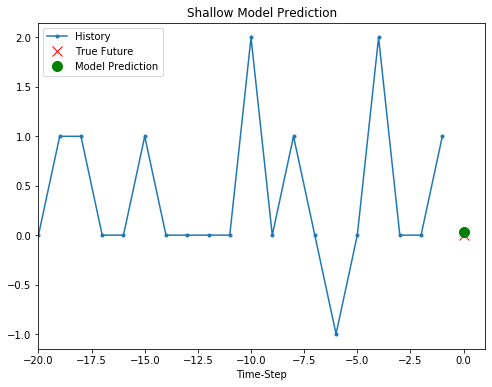

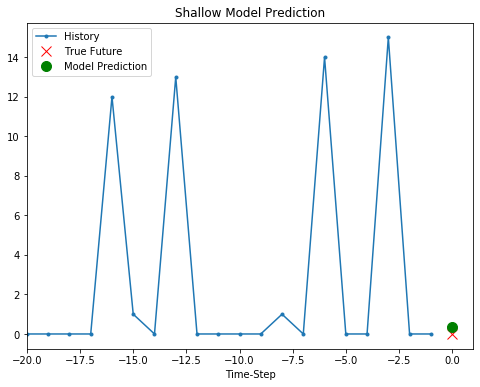

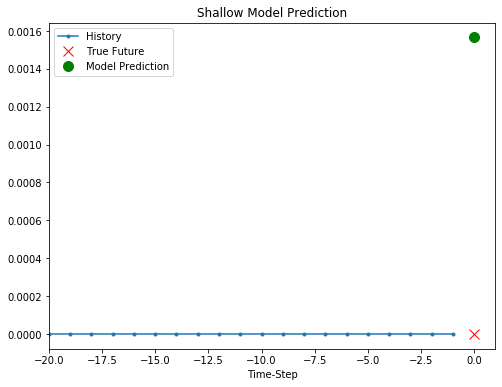

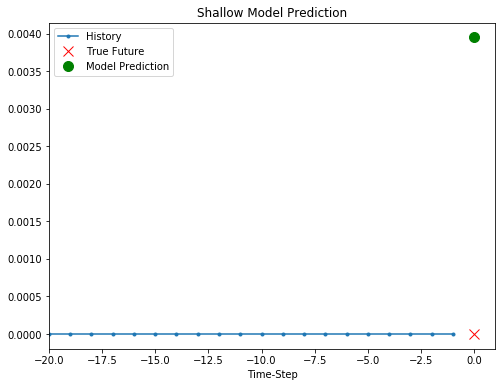

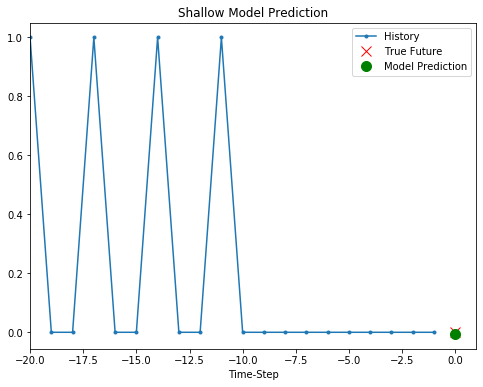

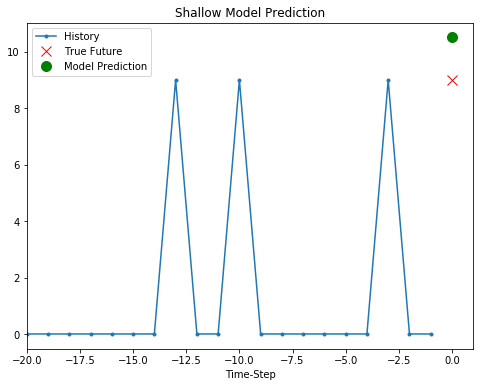

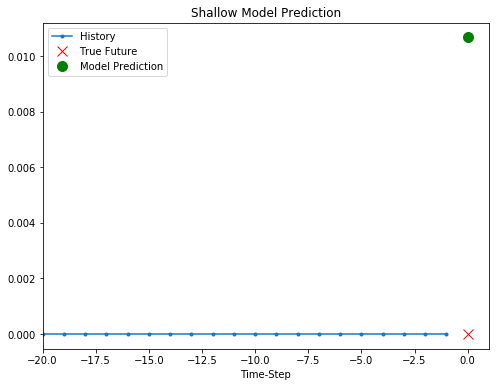

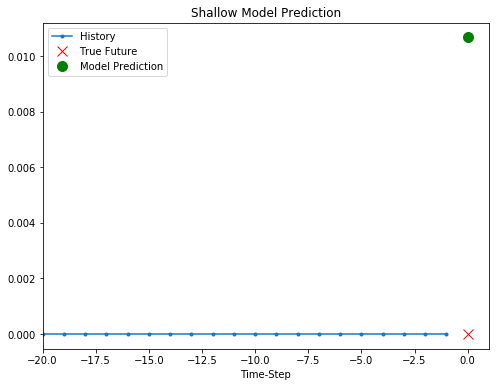

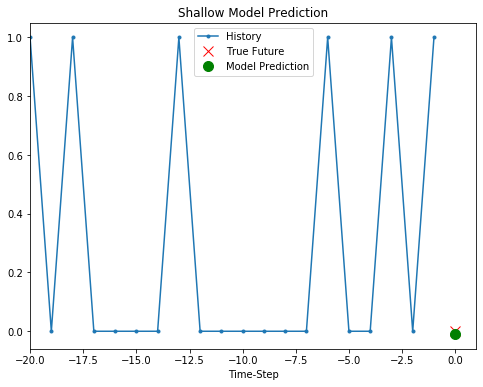

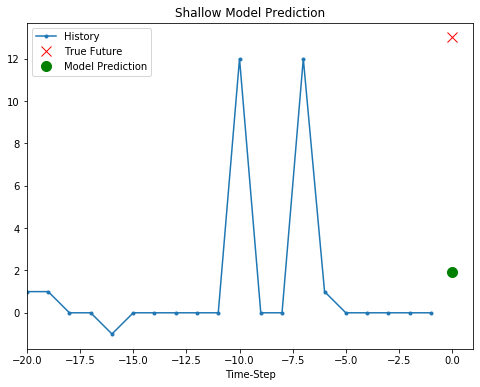

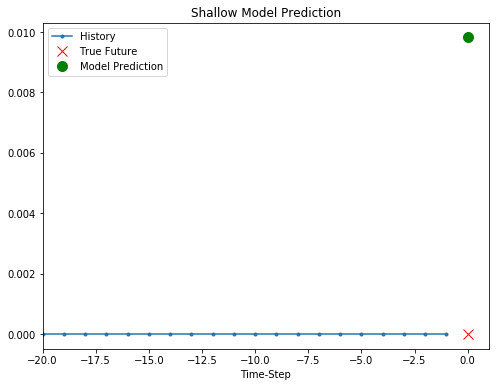

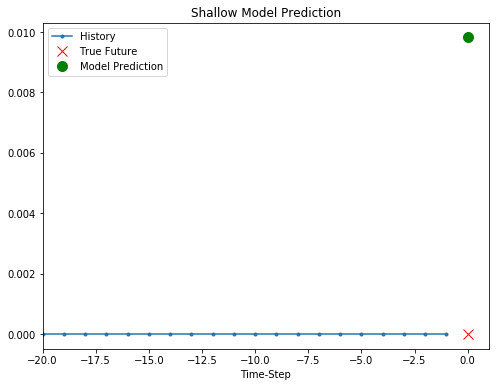

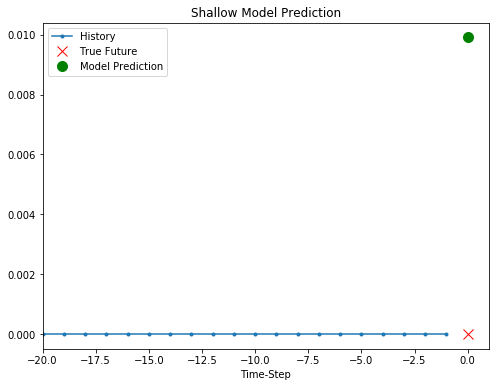

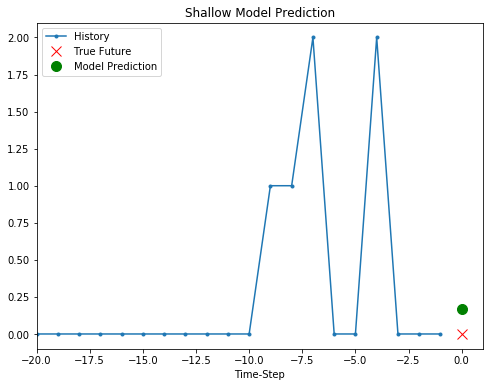

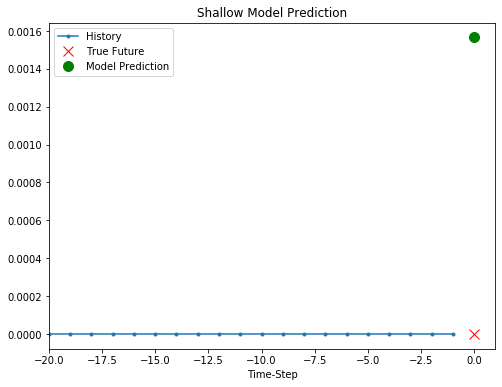

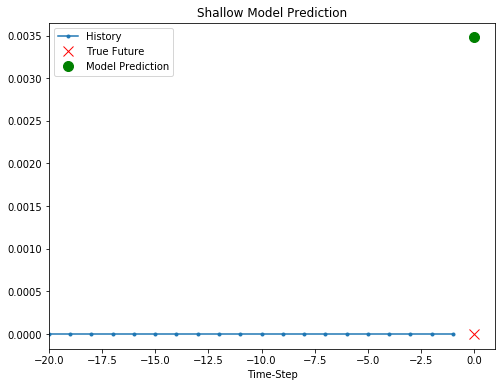

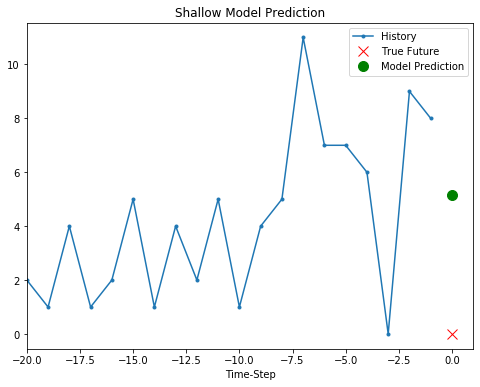

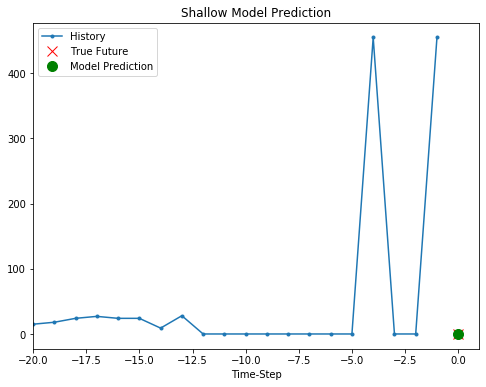

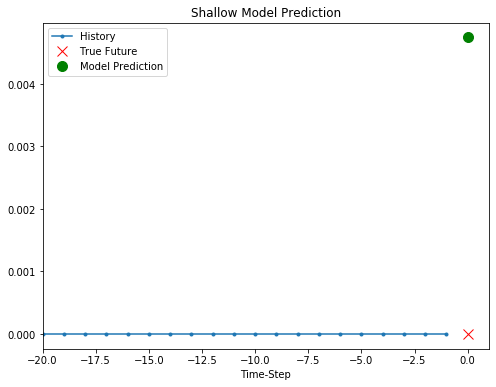

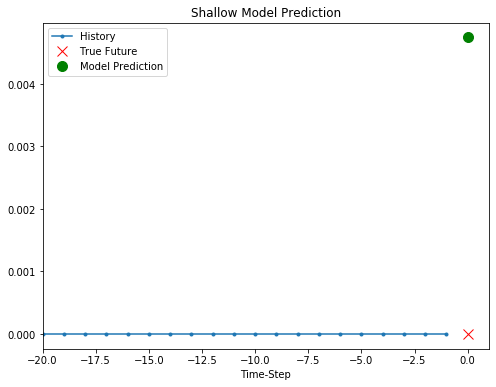

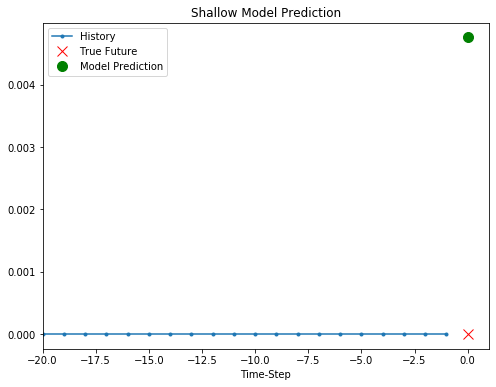

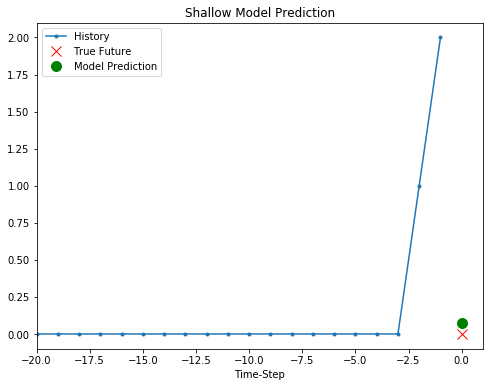

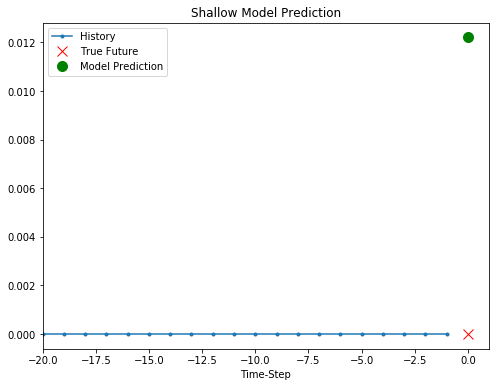

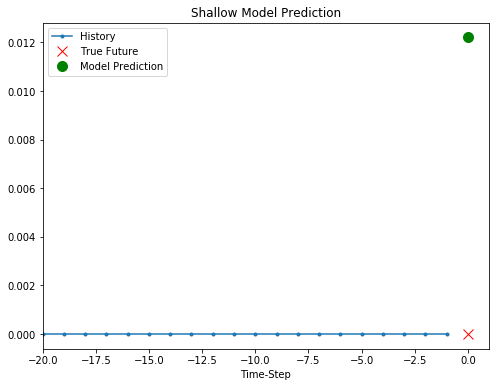

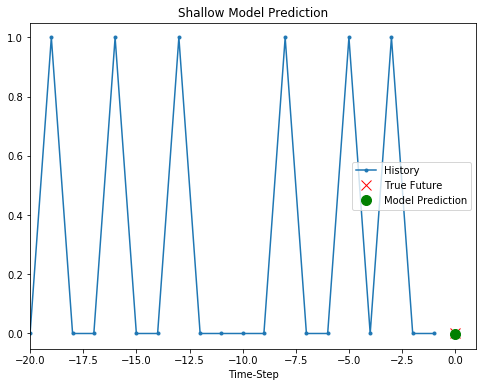

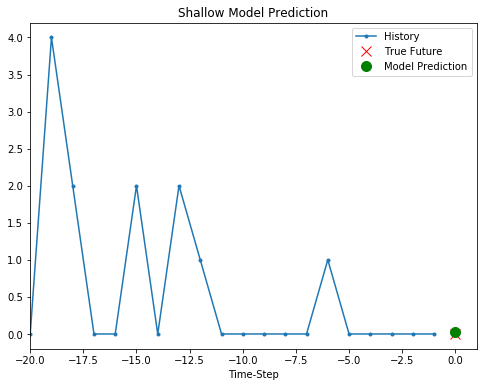

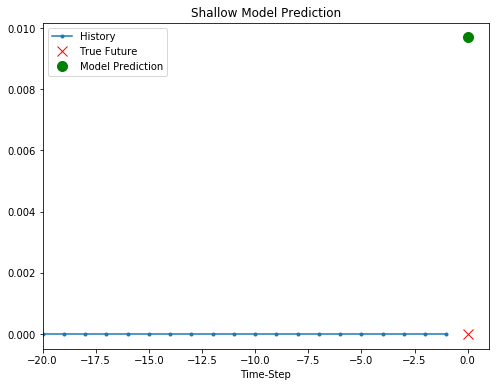

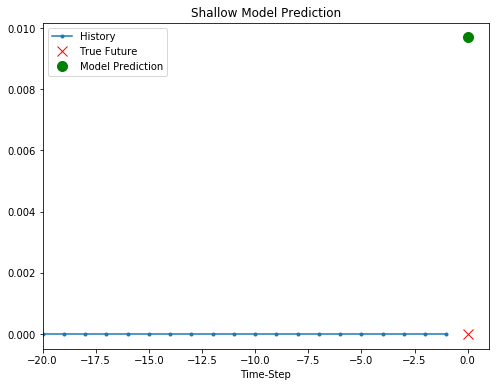

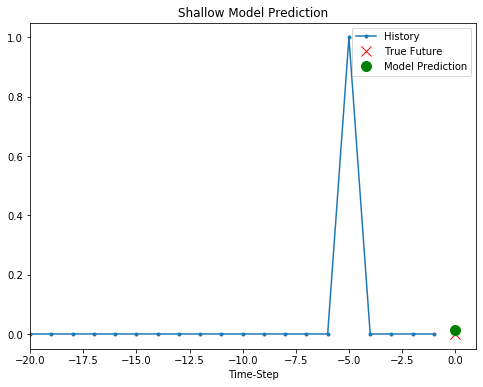

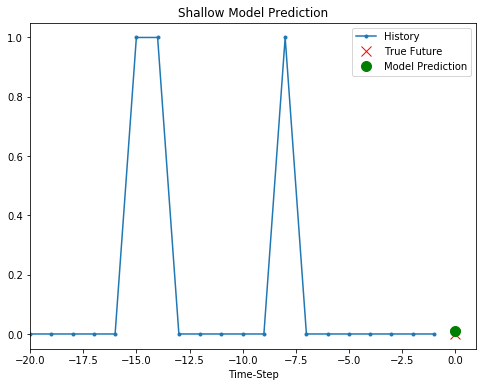

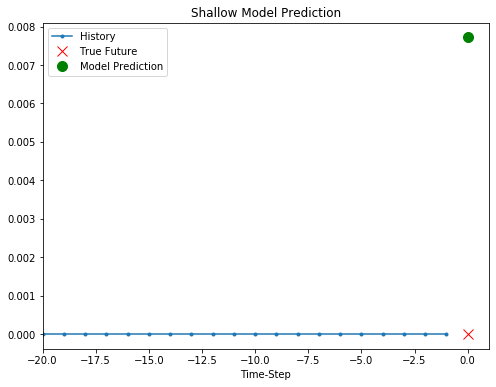

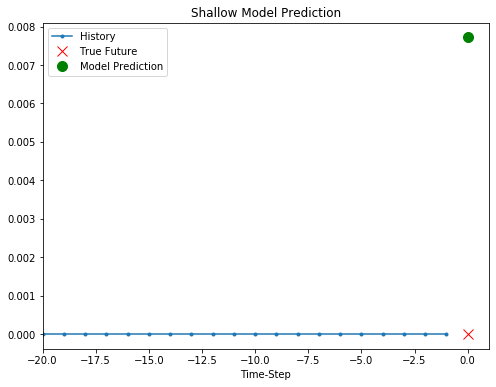

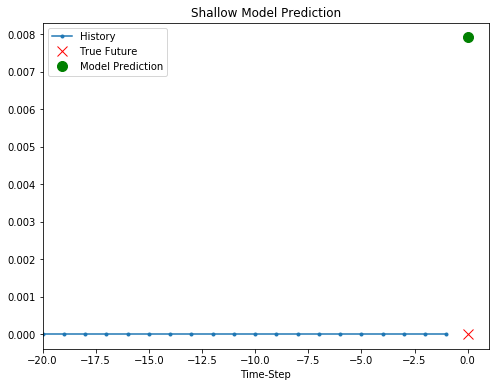

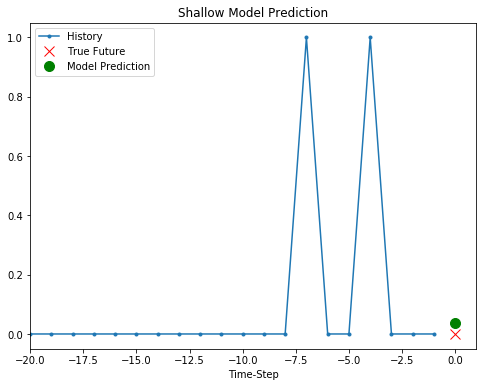

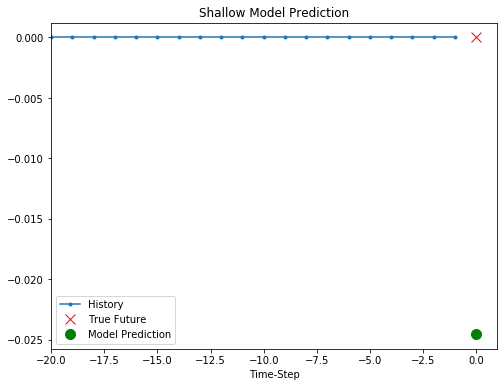

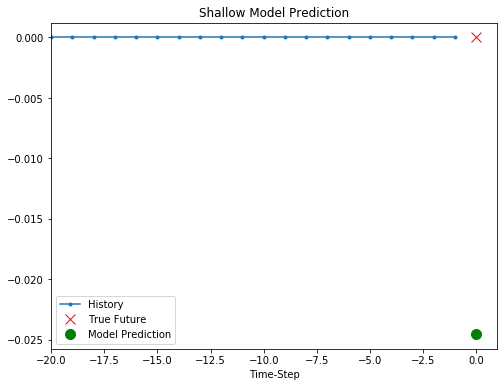

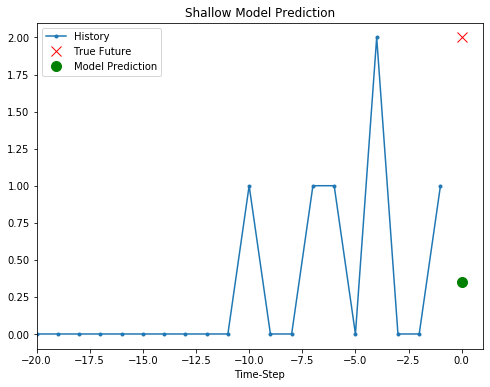

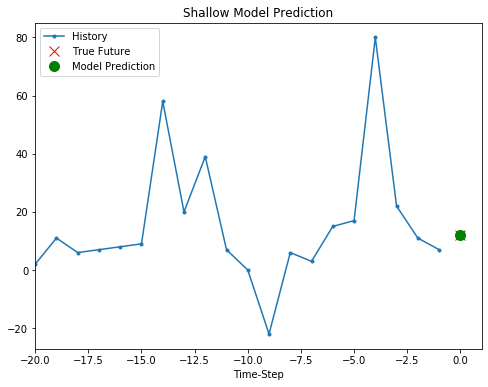

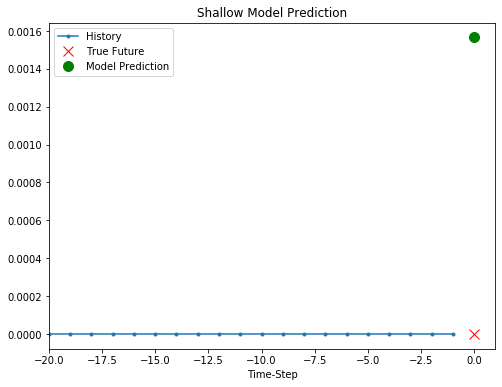

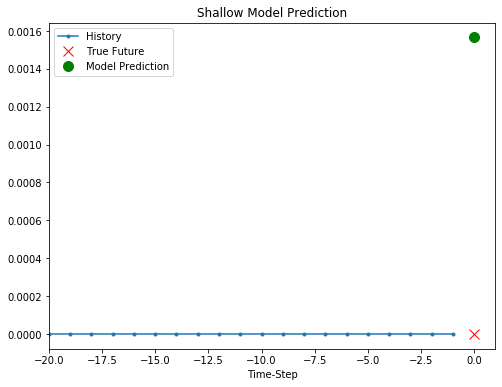

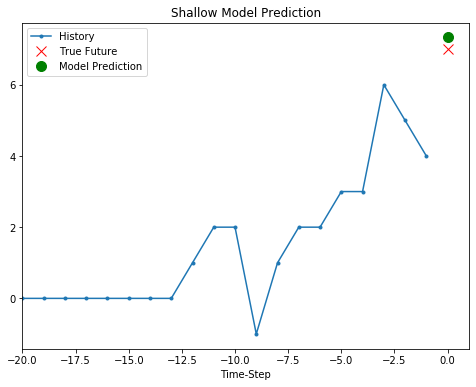

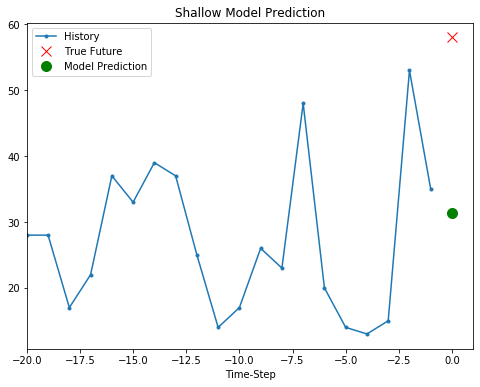

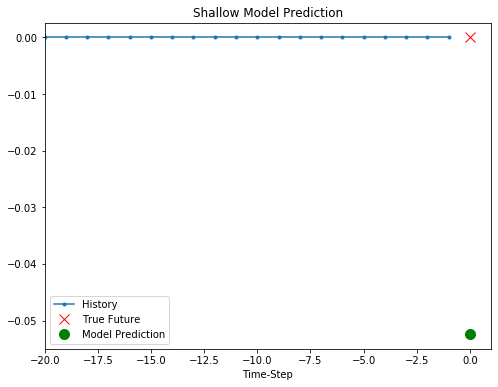

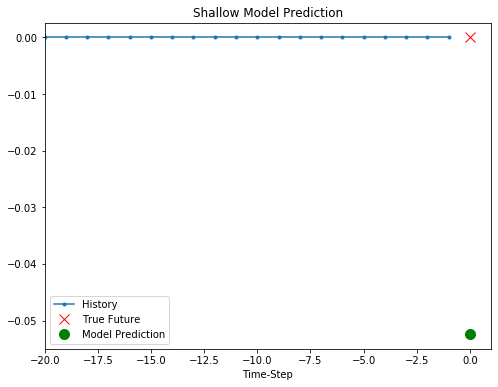

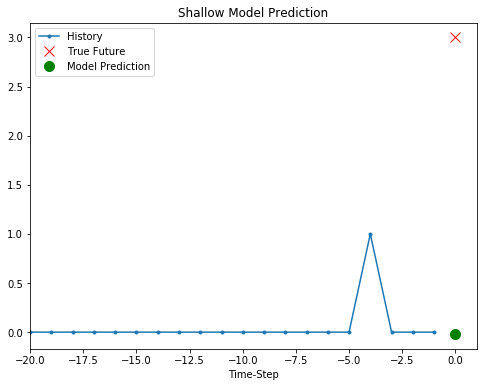

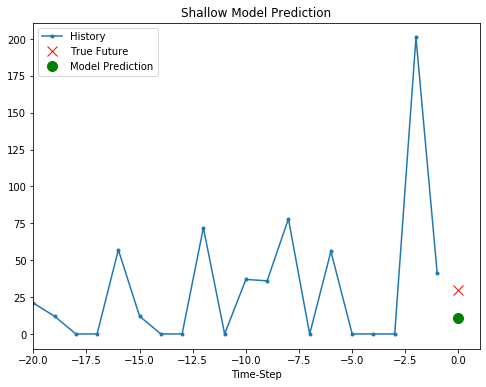

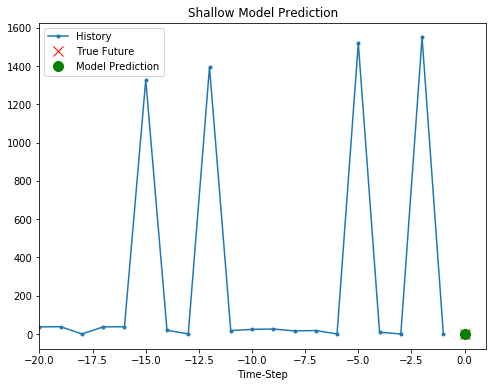

In [26]:
# shallow model
for x, y in val_data.skip(3000).take(50):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    shallow_model.predict(x)[0]], 0,
                   'Shallow Model Prediction')
    plot.show()

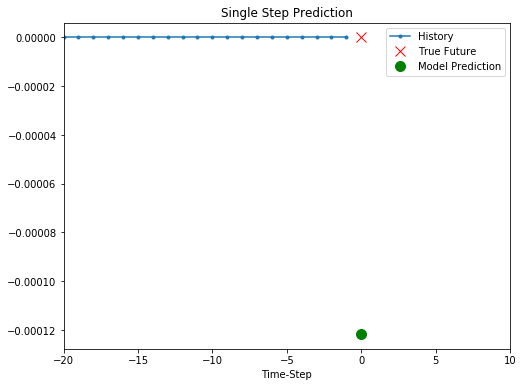

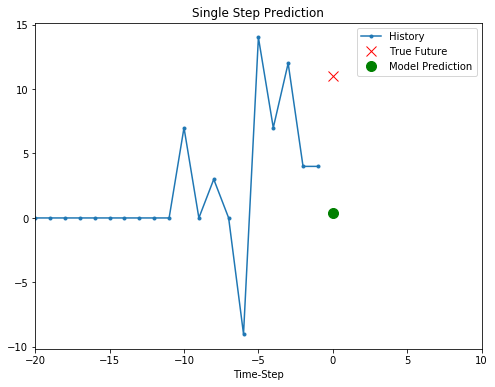

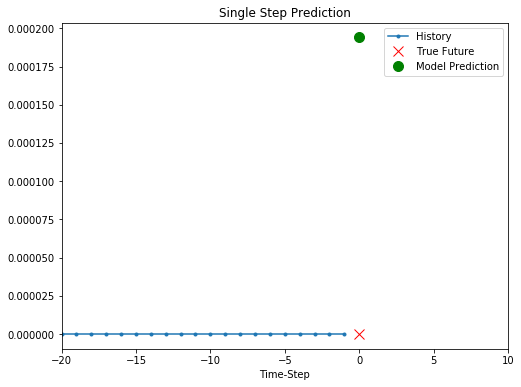

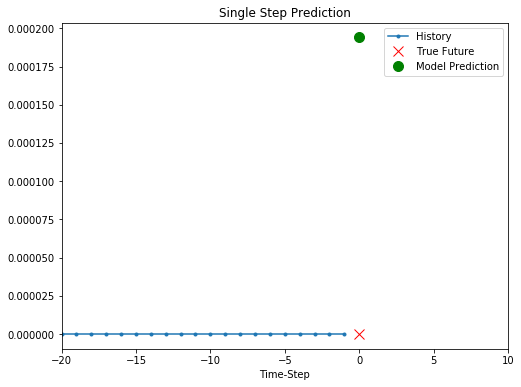

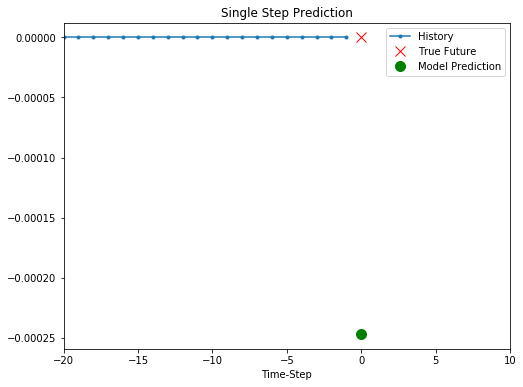

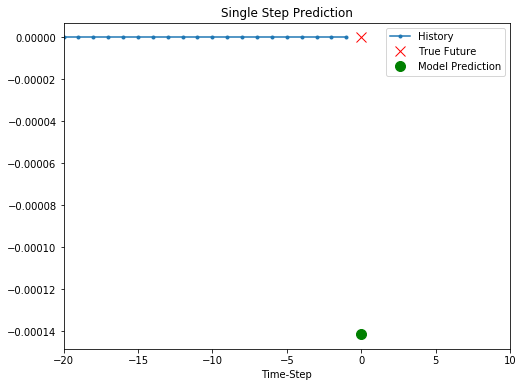

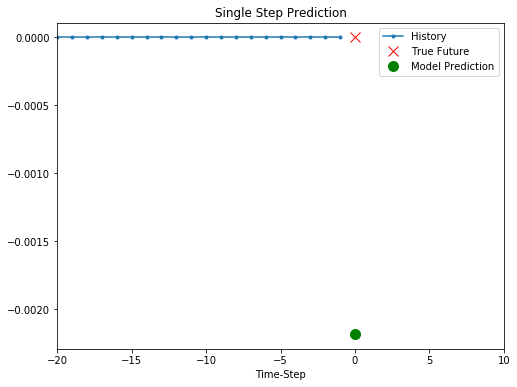

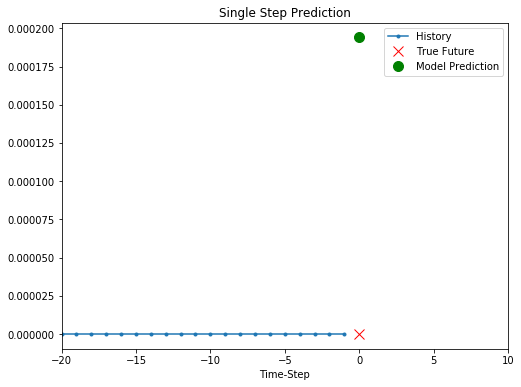

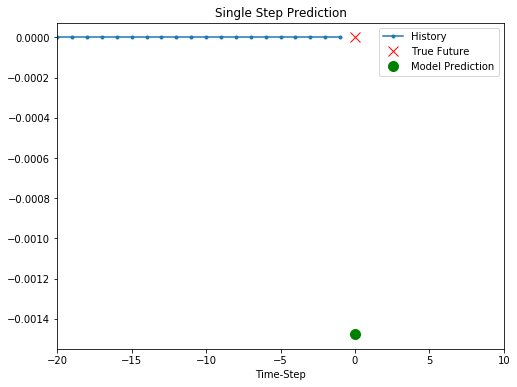

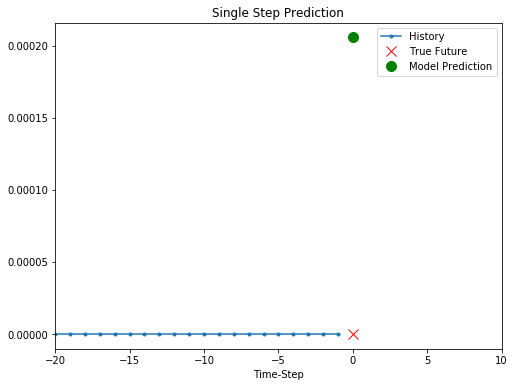

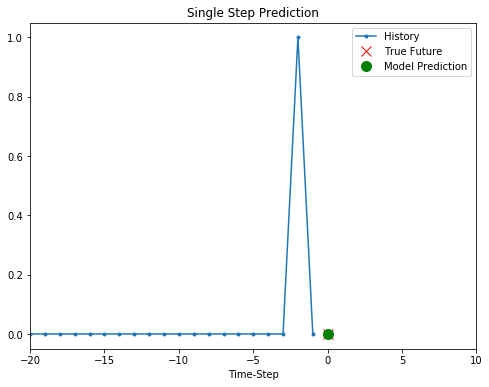

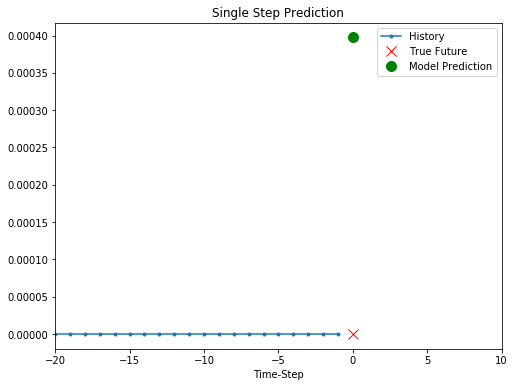

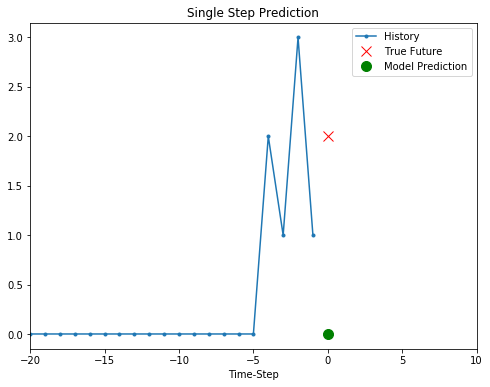

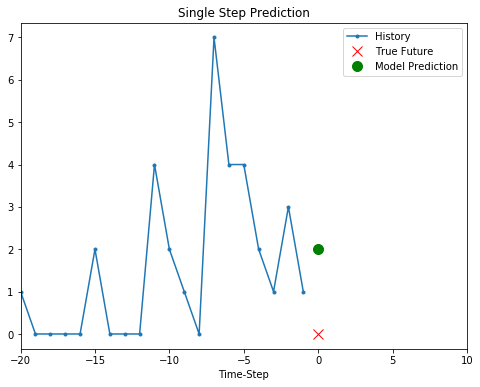

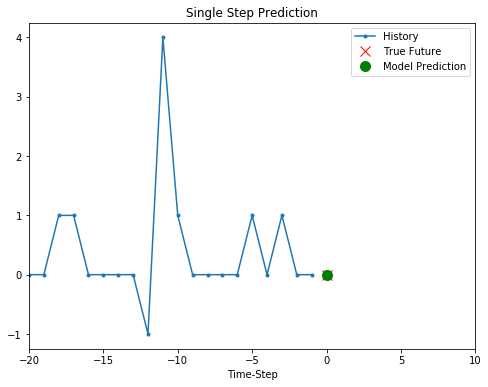

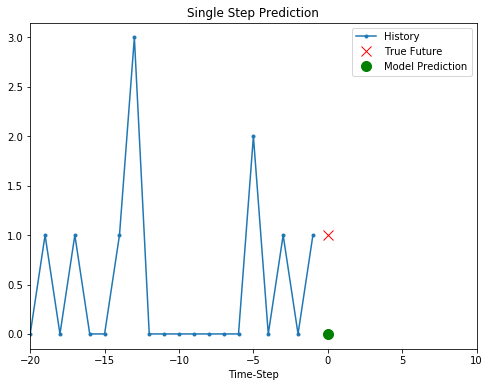

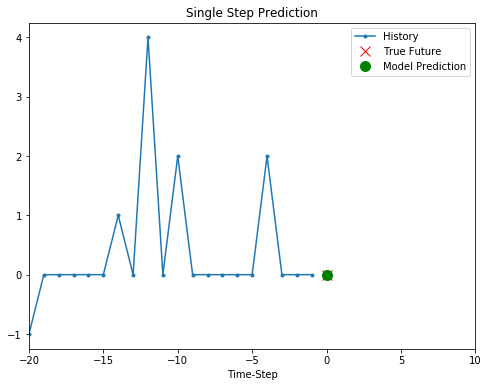

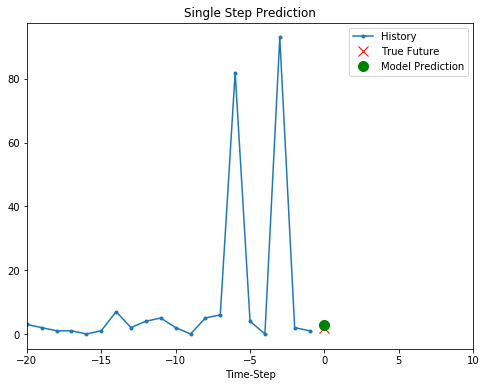

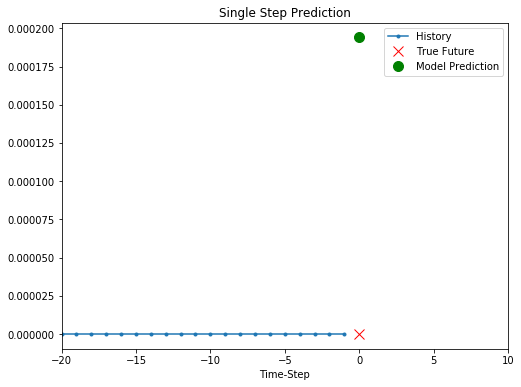

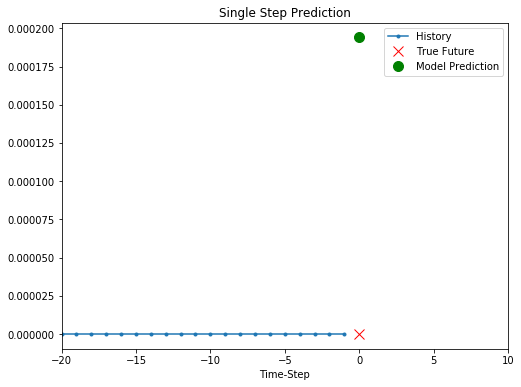

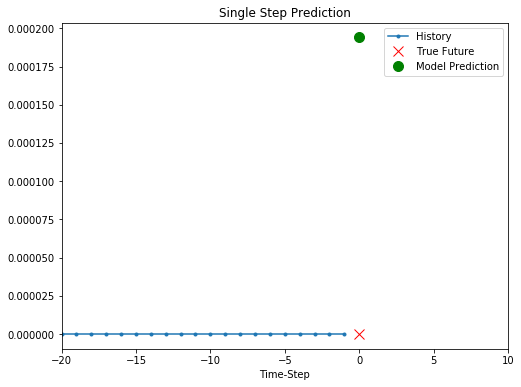

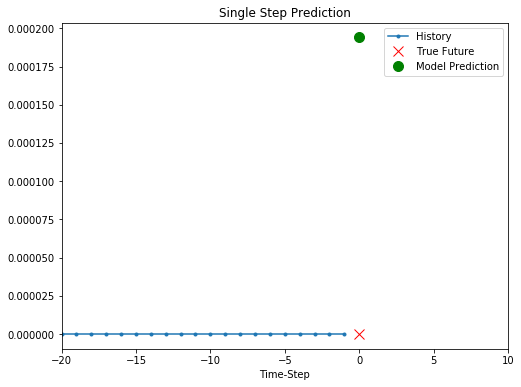

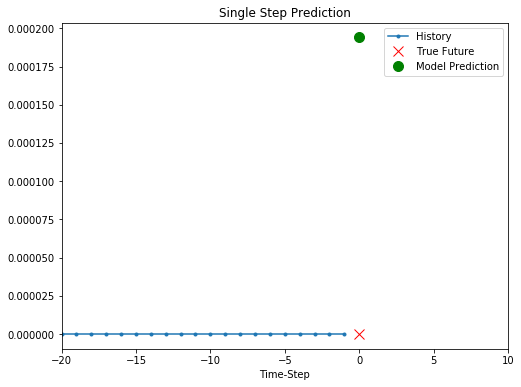

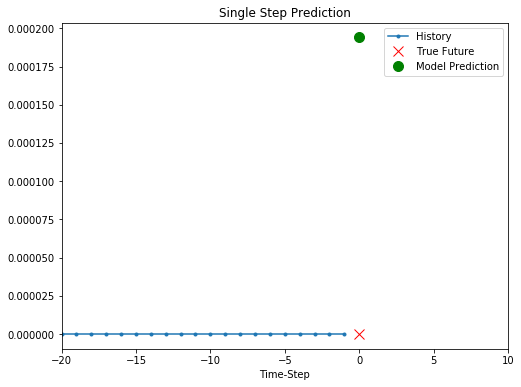

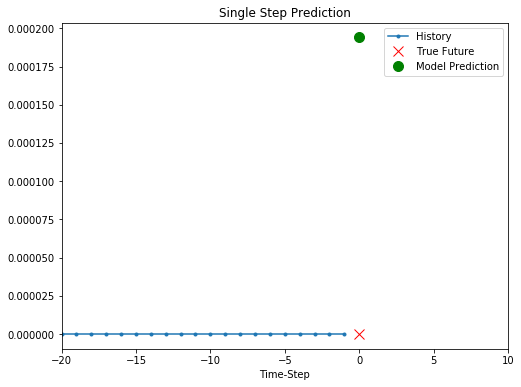

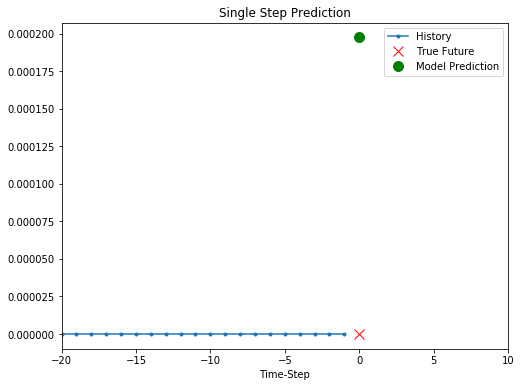

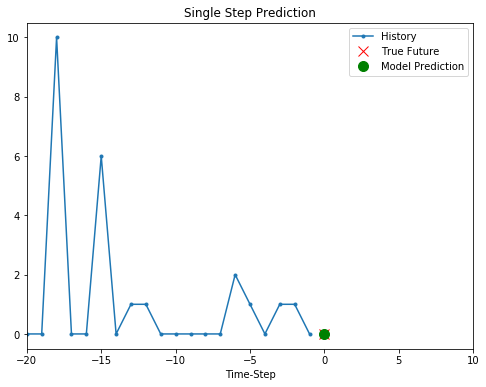

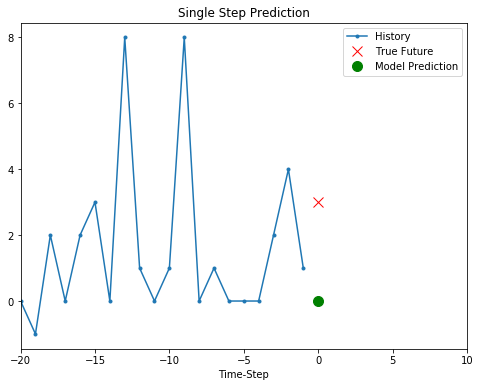

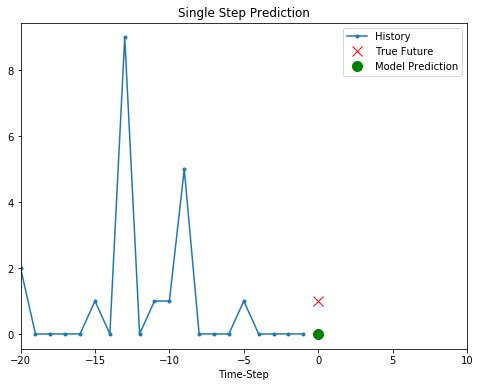

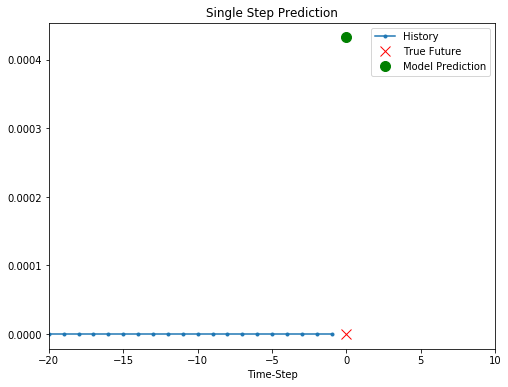

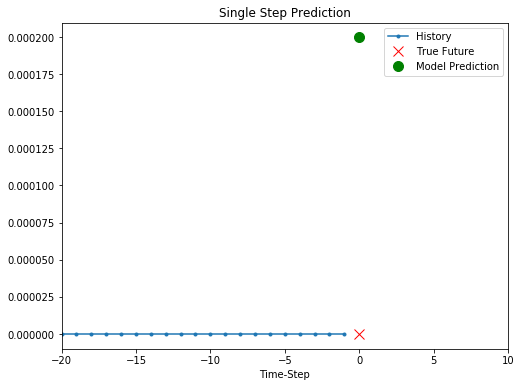

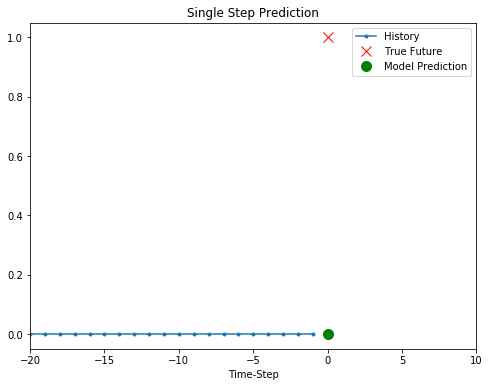

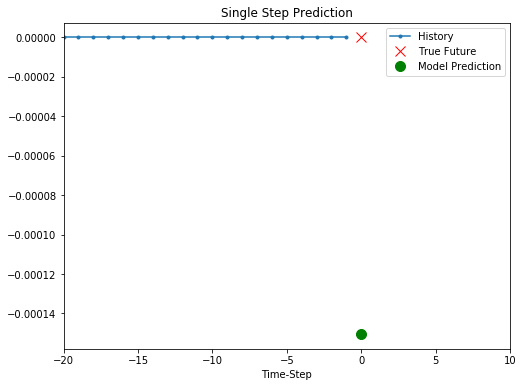

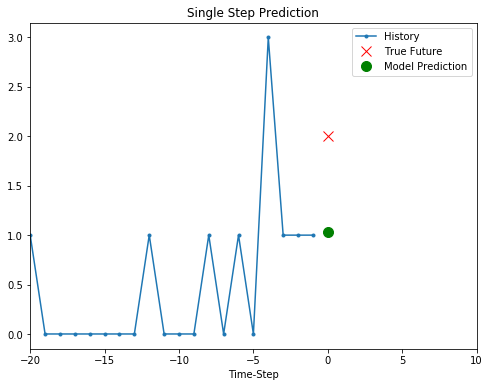

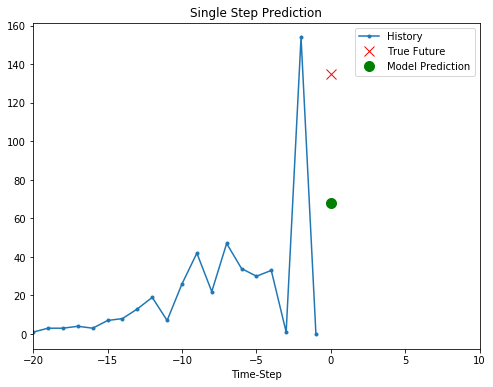

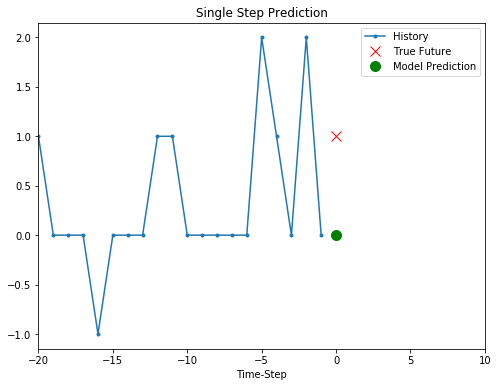

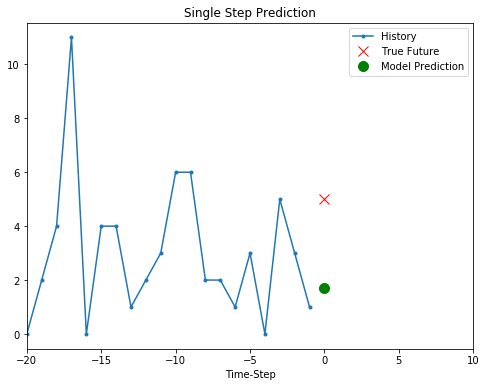

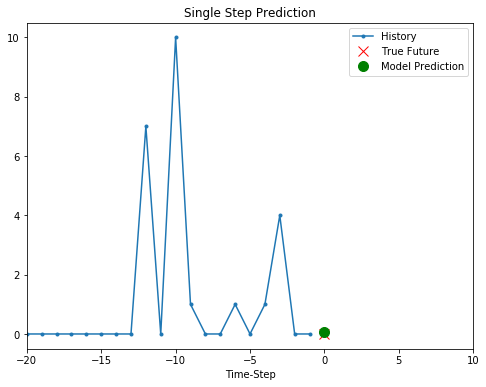

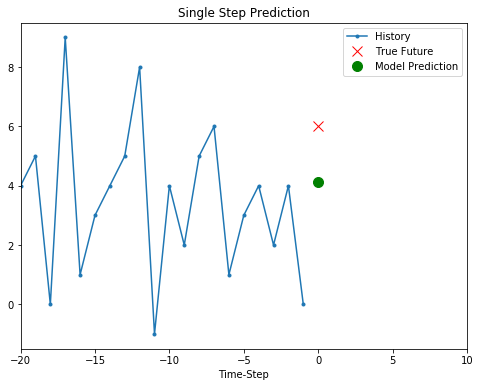

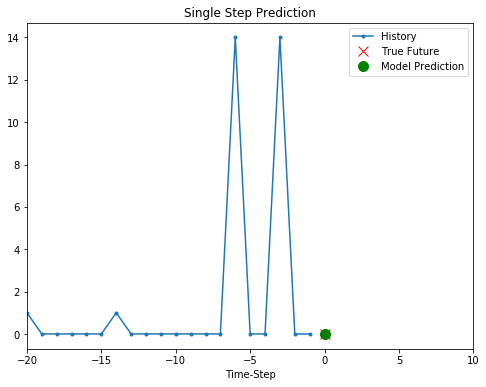

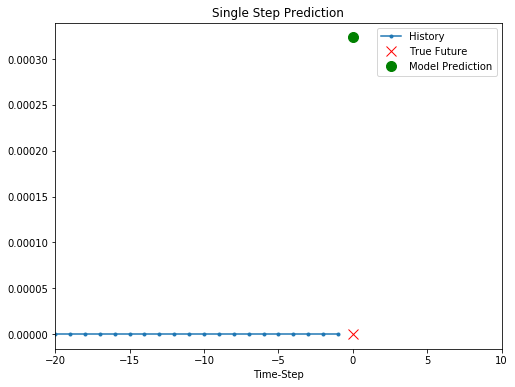

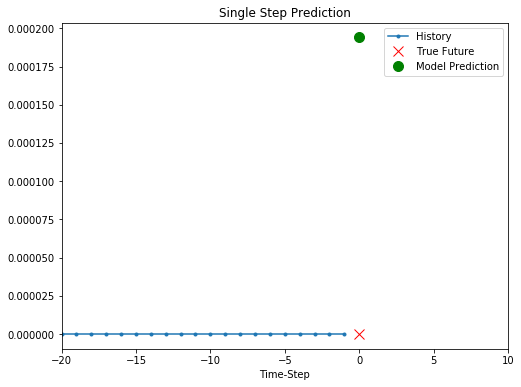

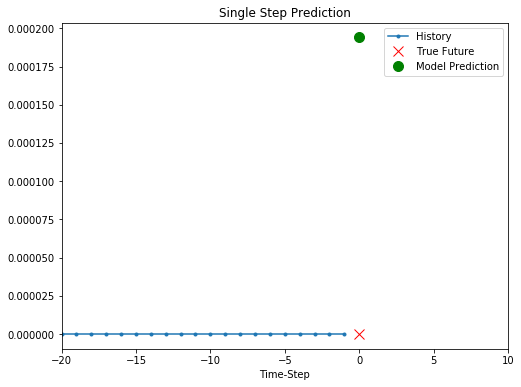

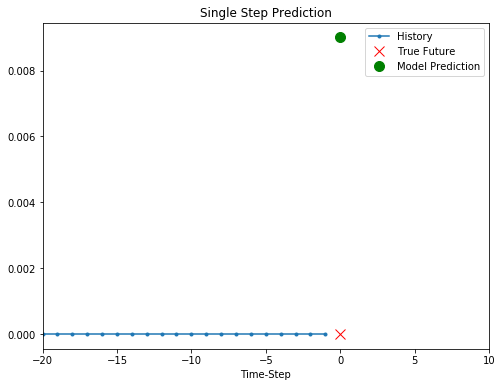

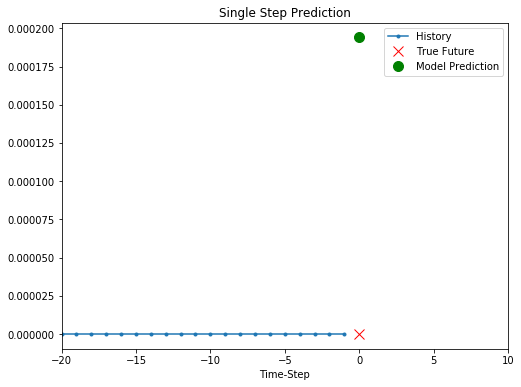

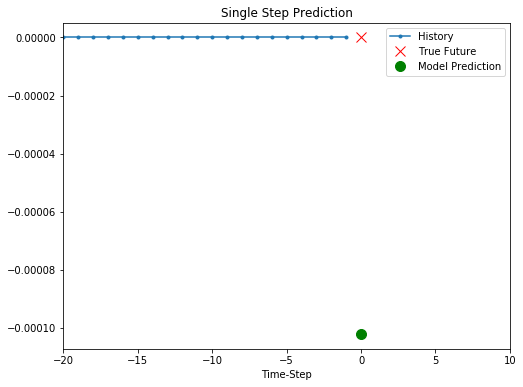

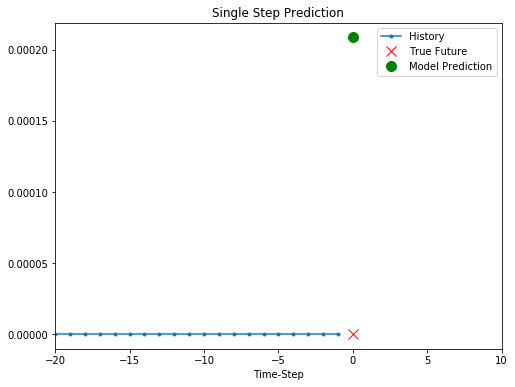

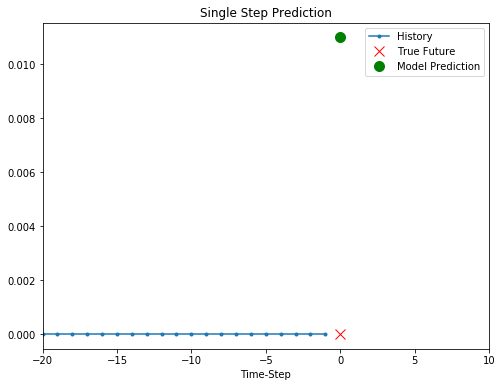

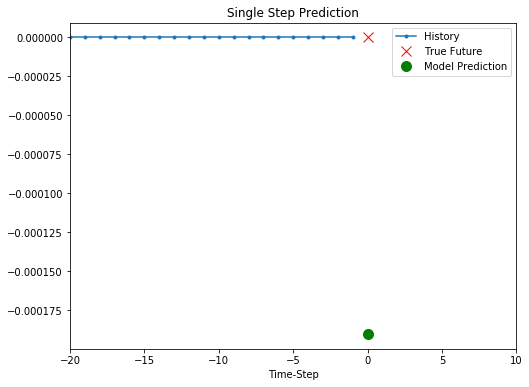

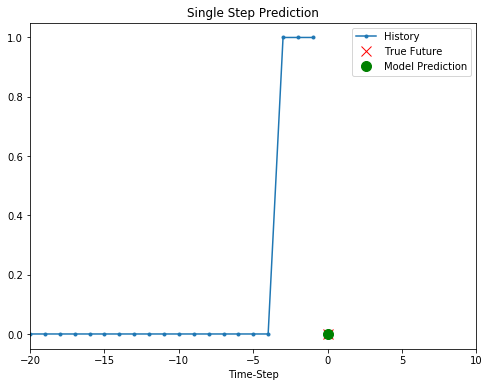

In [177]:
# deep model
for x, y in val_data.skip(3000).take(50):

    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    deep_model.predict(x)[0][0]], 0,
                   'Single Step Prediction')
    plot.show()

In [154]:
x = 0
y = 0
for x,y in val_data.skip(3000).take(10):
    pass
print(x[0][:, 1].numpy())
print( y[0].numpy())
print( model.predict(x)[0][-1])



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
-0.012613945


In [119]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [120]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

NameError: name 'train_data_multi' is not defined